<a href="https://colab.research.google.com/github/Isaac-Guz/PDI_IB_EneJun2025/blob/main/PIA__PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CARGAR Y MOSTRAR EN GRISES
Aquí se carga la imagen médica en escala de grises, lo cual es común en procesamiento digital debido a que simplifica el análisis. Se muestra la imagen original para tener un punto de referencia antes de aplicar transformaciones.

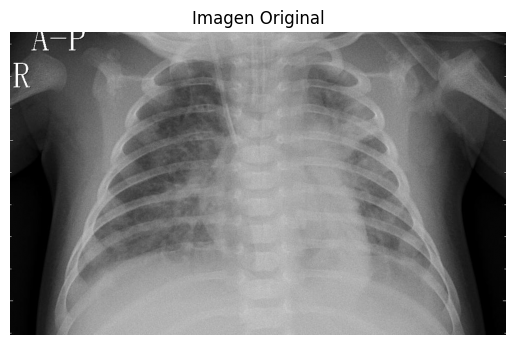

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar imagen (cambia el nombre según tu archivo)
img = cv2.imread(list(uploaded.keys())[0], cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')
plt.show()

ECUALIZAR HISTOGRAMA
Se analiza y ecualiza el histograma de la imagen. Esta técnica mejora el contraste global, permitiendo resaltar detalles que pueden estar ocultos en regiones muy oscuras o brillantes de la imagen médica.

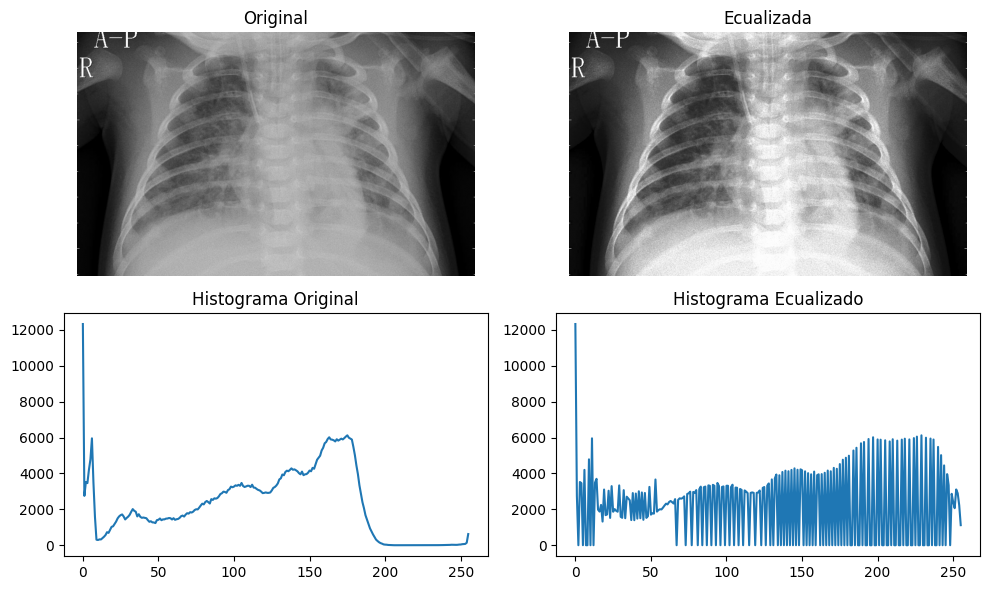

In [18]:
# Calcular histograma original
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])

# Ecualizar
img_eq = cv2.equalizeHist(img)
hist_eq = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

# Mostrar resultados
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original")
axs[0, 0].axis('off')
axs[0, 1].imshow(img_eq, cmap='gray')
axs[0, 1].set_title("Ecualizada")
axs[0, 1].axis('off')
axs[1, 0].plot(hist_original)
axs[1, 0].set_title("Histograma Original")
axs[1, 1].plot(hist_eq)
axs[1, 1].set_title("Histograma Ecualizado")
plt.tight_layout()
plt.show()

OPERACIONES ARITMETICAS Y LOGICAS
Se realizan operaciones entre imágenes para resaltar características importantes. Por ejemplo, al restar una versión suavizada de la imagen original, se destacan los bordes. También se aplican máscaras lógicas (AND) para enfocar zonas específicas de interés.

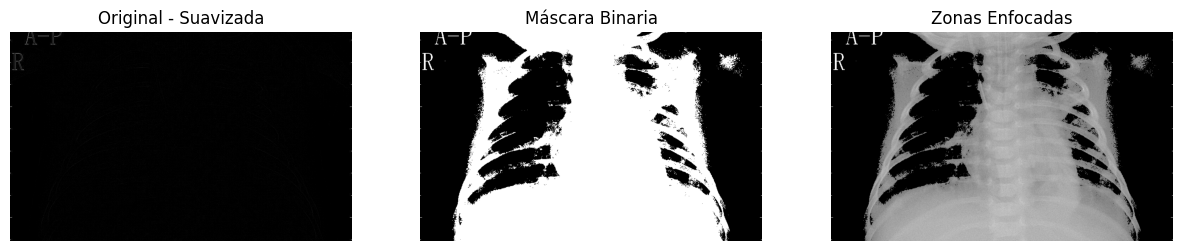

In [19]:
# Suavizado con filtro Gaussiano
blur = cv2.GaussianBlur(img, (5, 5), 0)
resaltado = cv2.subtract(img, blur)

# Máscara binaria
_, mascara = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
enfocado = cv2.bitwise_and(img, img, mask=mascara)

# Mostrar
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(resaltado, cmap='gray')
axs[0].set_title("Original - Suavizada")
axs[1].imshow(mascara, cmap='gray')
axs[1].set_title("Máscara Binaria")
axs[2].imshow(enfocado, cmap='gray')
axs[2].set_title("Zonas Enfocadas")
for ax in axs:
    ax.axis('off')
plt.show()

FILTROS
Se aplican filtros para eliminar ruido (pasa-bajo: media, gaussiano) y para detectar bordes (pasa-alto: Laplaciano, Sobel). Esto ayuda a diferenciar estructuras anatómicas o patológicas según su intensidad y contorno.

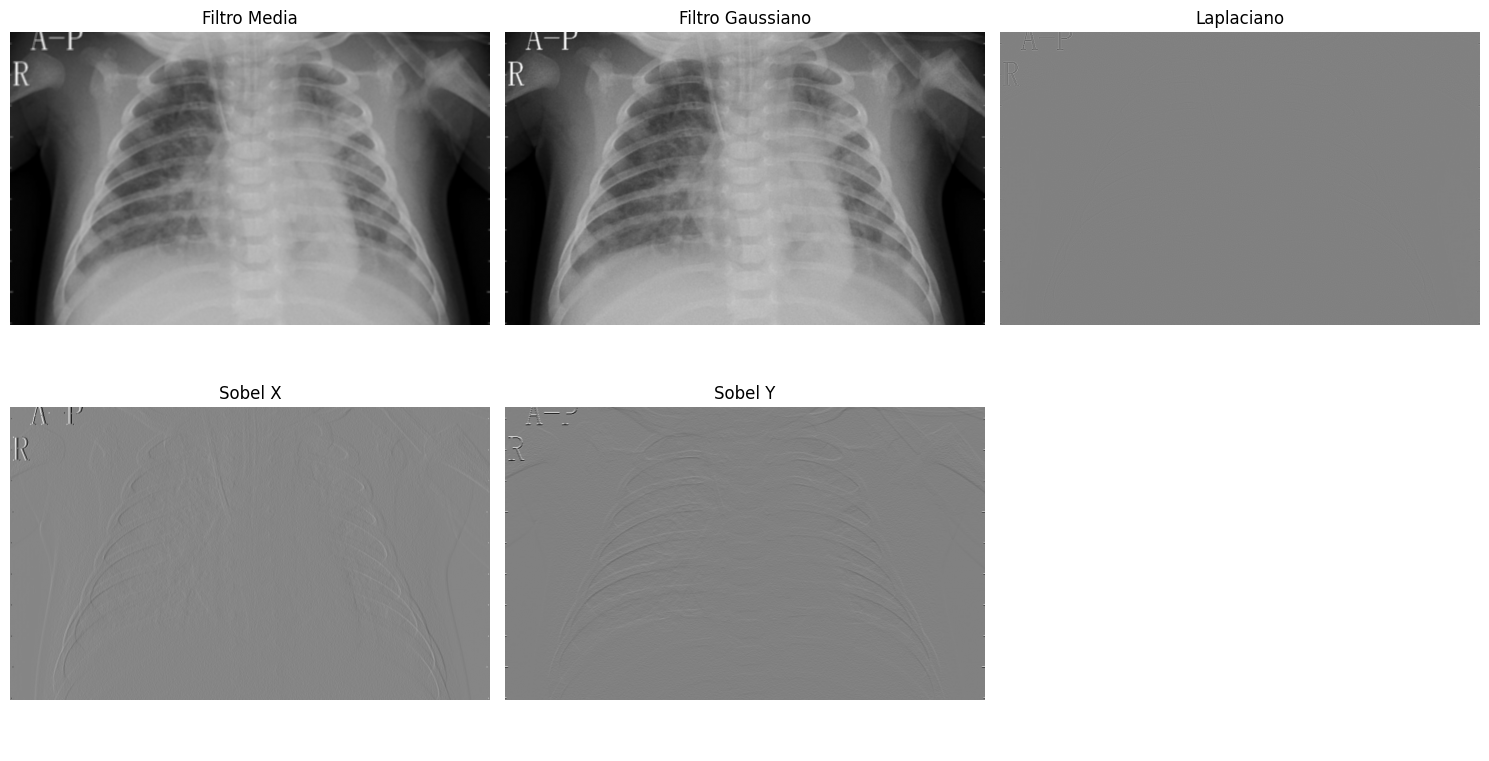

In [20]:
# Pasa-bajo
media = cv2.blur(img, (5, 5))
gauss = cv2.GaussianBlur(img, (5, 5), 0)

# Pasa-alto
laplaciano = cv2.Laplacian(img, cv2.CV_64F)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)

# Mostrar
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs[0, 0].imshow(media, cmap='gray'); axs[0, 0].set_title("Filtro Media")
axs[0, 1].imshow(gauss, cmap='gray'); axs[0, 1].set_title("Filtro Gaussiano")
axs[0, 2].imshow(laplaciano, cmap='gray'); axs[0, 2].set_title("Laplaciano")
axs[1, 0].imshow(sobelx, cmap='gray'); axs[1, 0].set_title("Sobel X")
axs[1, 1].imshow(sobely, cmap='gray'); axs[1, 1].set_title("Sobel Y")
axs[1, 2].axis('off')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


UMBRAL
Esta sección permite separar estructuras en la imagen usando un umbral. Al ajustar este valor, se pueden distinguir regiones como huesos, tejidos o posibles lesiones. Se incluye un control deslizante para probar diferentes valores y observar los resultados en tiempo real.

In [23]:
# Asegúrate de que 'img' está definida en una celda anterior (cargando la imagen)

def segmentar(umbral):
    """
    Segmenta la imagen utilizando un umbral dado y muestra el resultado.
    """
    # Aplica el umbral binario a la imagen
    _, segmented_img = cv2.threshold(img, umbral, 255, cv2.THRESH_BINARY)

    # Muestra la imagen segmentada
    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_img, cmap='gray')
    plt.title(f"Imagen Segmentada (Umbral={umbral})")
    plt.axis('off')
    plt.show()


# Se permite al usuario ajustar un umbral para segmentar la imagen.
# Esto ayuda a separar regiones como hueso y tejido blando.
interact(segmentar, umbral=IntSlider(min=0, max=255, step=5, value=128));


interactive(children=(IntSlider(value=128, description='umbral', max=255, step=5), Output()), _dom_classes=('w…

FOURIER
Aquí se transforma la imagen al dominio de la frecuencia para analizar sus componentes en baja y alta frecuencia. Luego, se aplica un filtro que atenúa las frecuencias altas, lo cual ayuda a eliminar detalles finos o ruido sin afectar las formas generales.

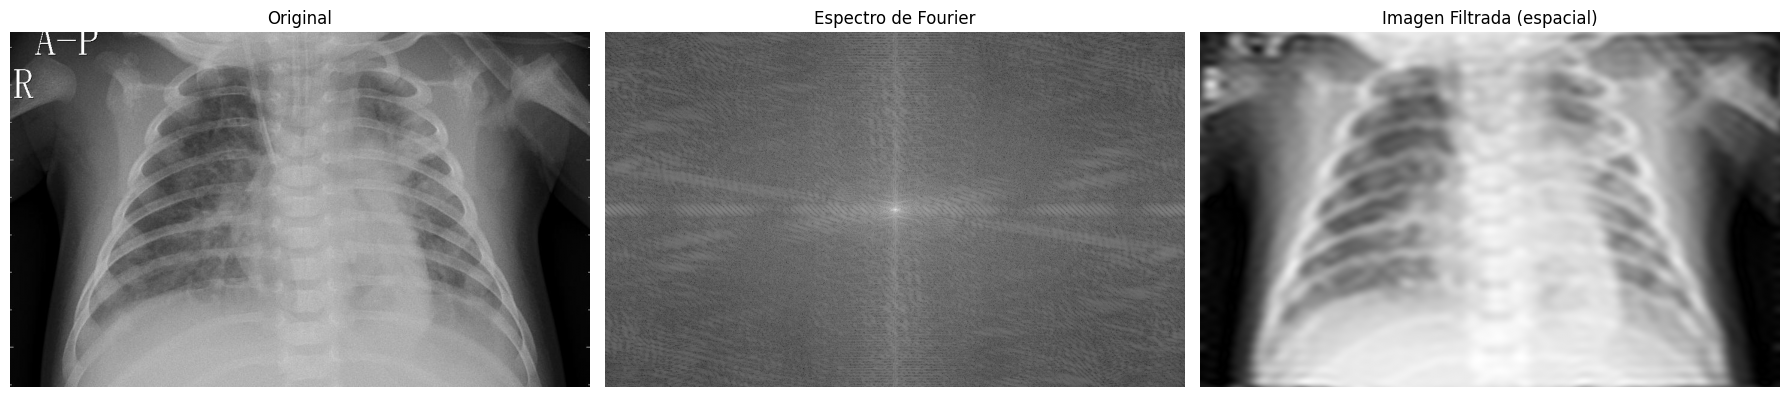

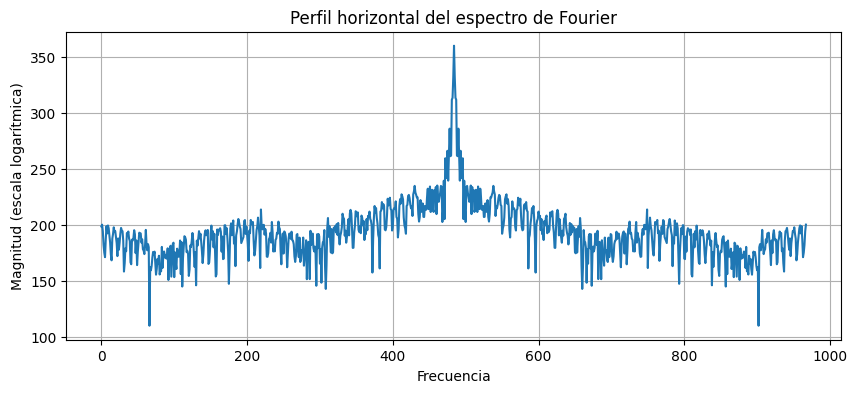

In [22]:
# Transformada de Fourier
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

# Crear máscara pasa-baja
rows, cols = img.shape
crow, ccol = rows//2, cols//2
mask = np.zeros((rows, cols), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# Aplicar filtro en frecuencia
fshift_filtered = fshift * mask
img_back = np.fft.ifft2(np.fft.ifftshift(fshift_filtered))
img_back = np.abs(img_back)

# Mostrar
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(img, cmap='gray'); axs[0].set_title("Original")
axs[1].imshow(magnitude_spectrum, cmap='gray'); axs[1].set_title("Espectro de Fourier")
axs[2].imshow(img_back, cmap='gray'); axs[2].set_title("Imagen Filtrada (espacial)")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Obtener el perfil horizontal (línea central del espectro)
linea_central = magnitude_spectrum[img.shape[0]//2, :]

# Graficar la magnitud del espectro en esa línea
plt.figure(figsize=(10,4))
plt.plot(linea_central)
plt.title("Perfil horizontal del espectro de Fourier")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud (escala logarítmica)")
plt.grid(True)
plt.show()